In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Ridge

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Interactive widget
from ipywidgets import interact


# Retina mode
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [18]:
# Download CO2 data from NOAA
url = 'https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv'

names = 'year,month,decimal date,average,deseasonalized,ndays,sdev,unc'.split(',')

# no index
df = pd.read_csv(url, skiprows=72, names=names, index_col=False)

In [19]:
df.index = pd.to_datetime(df[['year', 'month']].apply(lambda x: '{}-{}'.format(x[0], x[1]), axis=1))

In [20]:
# Create X and y

# X = months since first measurement

X = np.array(range(len(df)))
y = df.average.values

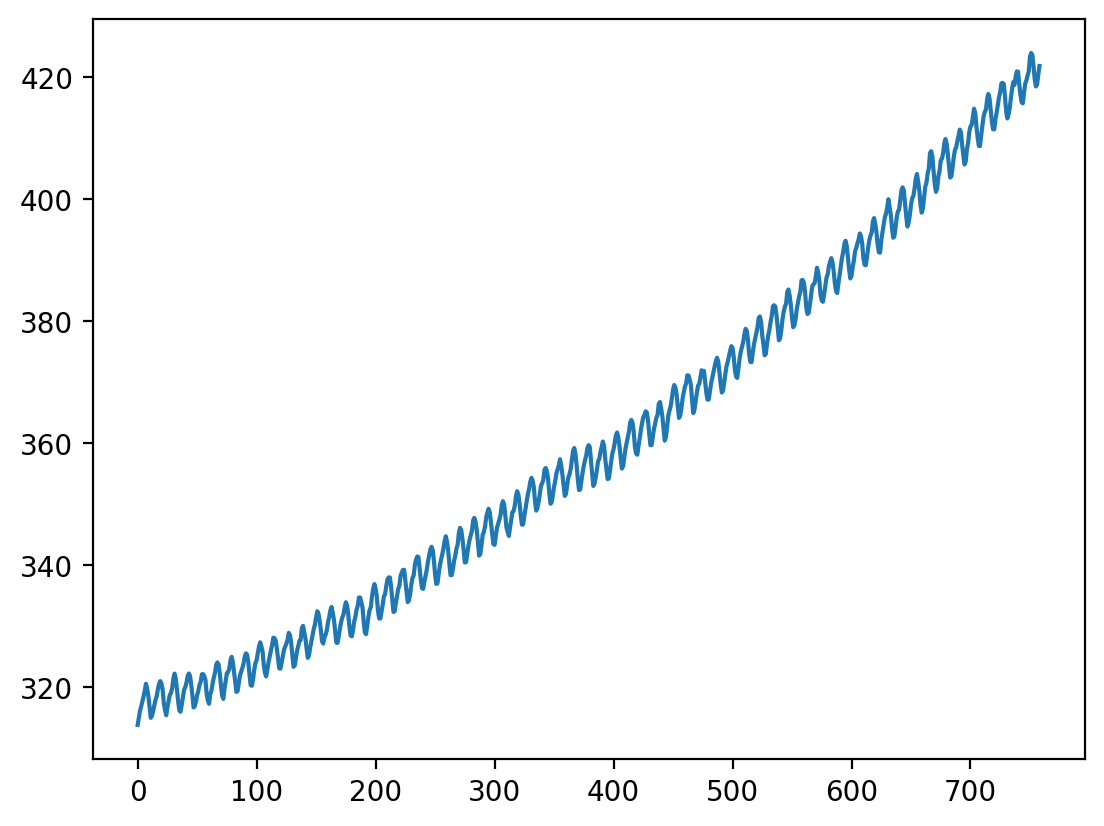

In [21]:
plt.plot(X, y)

<h2>Auto Regressive Model</h2>

We convert the CO2 level time sequence into an input feature matrix and the corresponding output vector by setting a <i>lag</i> value. A sliding window of <i>lag</i> length will be used across the sequence to create the feature matrix and the output.

In [22]:
# making the features using previous values according to lag
def make_dataset(y, X, lag):
    X_train = []
    y_train = []
    months = []
    for i in range(len(y)-lag):
        row = y[i:i+lag]
        y_train.append(y[i+lag])
        X_train.append(row)

        month_value = X[i+lag]
        months.append(month_value)

    X_train = pd.DataFrame(X_train)
    y_train = pd.Series(y_train)
    return X_train, y_train, months

In [23]:
# adding the month value as a feature
def make_dataset_with_month(y, X, lag):
    X_train = []
    y_train = []
    months_train = []

    for i in range(len(y)-lag):
        row = y[i:i+lag]
        y_train.append(y[i+lag])
        X_train.append(row)

        month_value = X[i+lag]
        months_train.append(month_value)

    X_train = pd.DataFrame(X_train)
    X_train[10] = months_train
    y_train = pd.Series(y_train)

    return X_train, y_train, months_train


In [24]:
# Spliting the data into train and test, 80:20 split
y = y.flatten().tolist()
split_index = int(0.8 * len(y))

train_data = y[:split_index]
X_train_data = X[:split_index]
test_data = y[split_index:]
X_test_data = X[split_index:]

In [25]:
# example run of the model using a lag of 10
lag = 10
X_train, y_train, months_train = make_dataset(train_data, X_train_data, lag)
reg = LinearRegression().fit(X_train, y_train)
X_test, y_test, months_test = make_dataset(test_data,X_test_data, lag)
y_hat = reg.predict(X_test)
mse = mean_squared_error(y_test, y_hat)

print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.2099165801507042


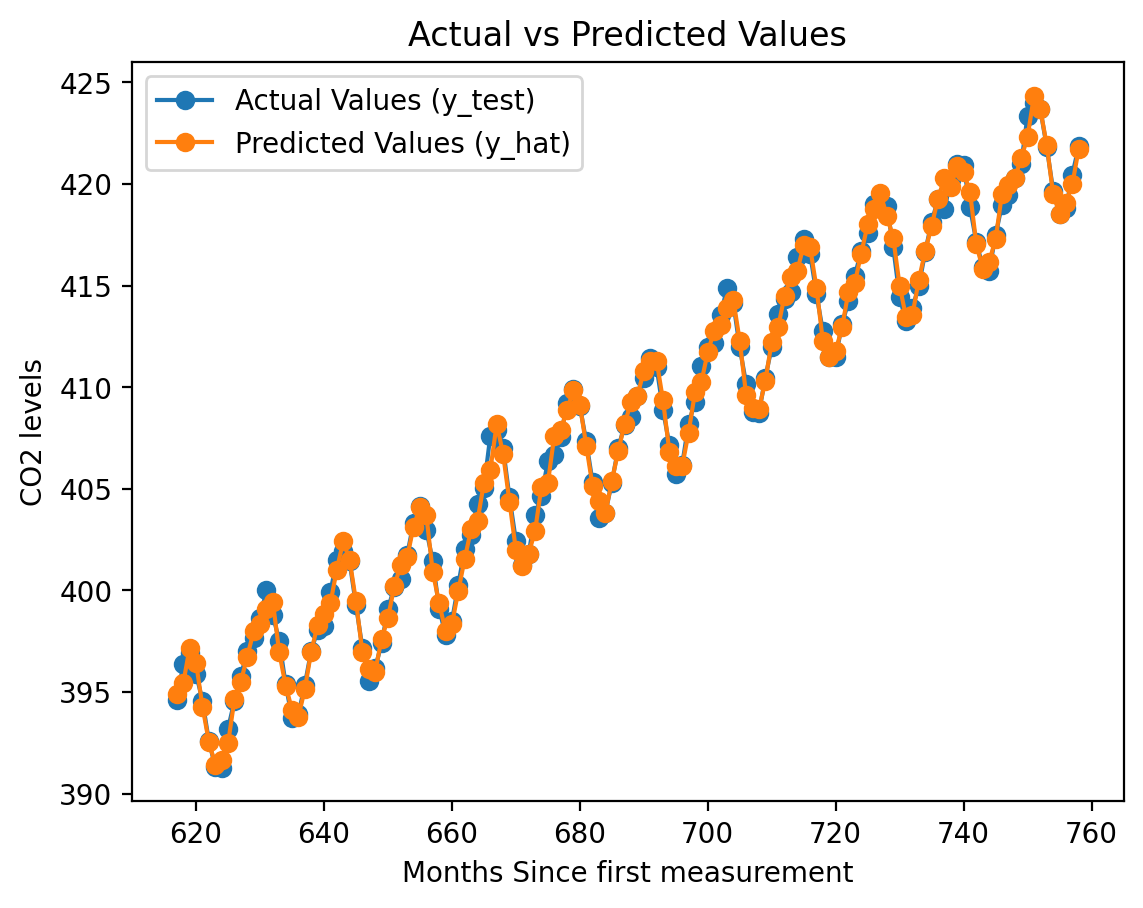

In [26]:
# Ploting the predicted output for lag=10 for the test sequence
plt.plot(months_test, y_test, label='Actual Values (y_test)', marker='o')
plt.plot(months_test, y_hat, label='Predicted Values (y_hat)', marker='o')
plt.xlabel('Months Since first measurement')
plt.ylabel('CO2 levels')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [27]:
# Creating a custom class for training and testing the AR model for different lag values
class AR_model:

  def __init__(self, lag, add_month = False):
    self.reg = LinearRegression()
    self.lag = lag
    self.add_month = add_month

  def train_AR_model(self, train_data, X_train_data):

    if(self.add_month):
      X_train, y_train, month_train = make_dataset_with_month(train_data, X_train_data, self.lag)
      self.reg.fit(X_train, y_train)

    else:
      X_train, y_train, months_train = make_dataset(train_data, X_train_data, self.lag)
      self.reg.fit(X_train, y_train)

    return self.reg

  def test_AR_model(self, test_data,X_test_data):
    if(self.add_month):
      X_test, y_test, month_test = make_dataset_with_month(test_data,X_test_data, self.lag)
      y_hat = self.reg.predict(X_test)
      mse = mean_squared_error(y_test, y_hat)


    else:
      X_test, y_test, months_test = make_dataset(test_data,X_test_data, self.lag)
      y_hat = self.reg.predict(X_test)
      mse = mean_squared_error(y_test, y_hat)

    return mse



In [28]:
# Finding the variation in the mse values with increasing lag

lag_values = [1, 5, 10, 15, 20, 30, 35, 40, 50, 55, 65]

# Compairing the accuracy of the models with and without the month feature
loss_table_1 = []
loss_table_2 = []

for lag in lag_values:
    model_1 = AR_model(lag)
    model_2 = AR_model(lag, True)
    reg1 = model_1.train_AR_model(train_data, X_train_data)
    reg2 = model_2.train_AR_model(train_data, X_train_data)

    mse1 = model_1.test_AR_model(test_data,X_test_data)
    mse2 = model_2.test_AR_model(test_data,X_test_data)
    loss_table_1.append((lag, mse1))
    loss_table_2.append((lag, mse2))



In [29]:
print("Lag\t\tMSE")
for lag, mse in loss_table_1:
    print(f"{lag}\t\t{mse}")




Lag		MSE
1		1.817134104473476
5		0.7112076294569203
10		0.2099165801507042
15		0.15837080084406413
20		0.15997452174647026
30		0.1399319909539809
35		0.13661458170715188
40		0.13807827254170973
50		0.15227866041392218
55		0.15667404055943937
65		0.1357603846316994


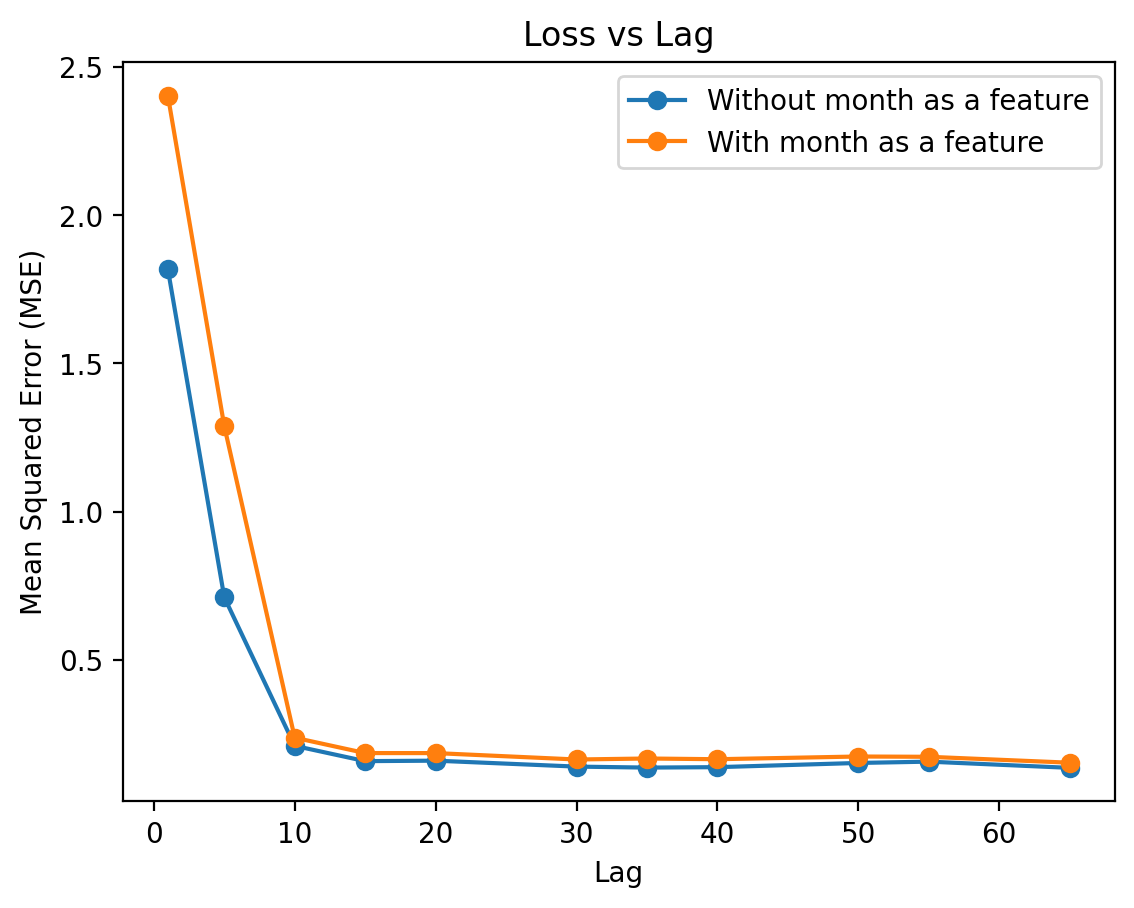

In [30]:
# Visualize the loss values
lags, losses1 = zip(*loss_table_1)
lags, losses2 = zip(*loss_table_2)
plt.plot(lags, losses1,label='Without month as a feature', marker='o')
plt.plot(lags, losses2,label='With month as a feature', marker='o')
plt.xlabel('Lag')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Loss vs Lag')
plt.legend()
plt.show()

<h2> Comparison with other models: </h2>

1. Simple Linear Regression (without any auto regressive components)
2. Simple LSTM ( One hidden layer and an output layer )

In [31]:
# Simple linear regression model that uses just the month value as the input
reg_slr = LinearRegression().fit(np.array(X_train_data).reshape(-1, 1), train_data)
y_hat_slr = reg_slr.predict(np.array(X_test_data).reshape(-1, 1))
mse_slr = mean_squared_error(test_data, y_hat_slr)

print(f"Mean Squared Error (MSE) for Simple Linear Regression: {mse_slr}")

Mean Squared Error (MSE) for Simple Linear Regression: 133.76398868834795


<h3> LSTM (single hidden layer)

In [32]:
# Create and fit a simple LSTM model
from keras.models import Sequential
from keras.layers import LSTM, Dense

lag = 5
n_features = 1
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(lag, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [33]:
from numpy import array

# Preparing the data for training and testing the model
X_train, y_train, months_train = make_dataset(train_data, X_train_data, lag)
X_train = array(X_train)
y_train = array(y_train)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
model.fit(X_train, y_train, epochs=200, verbose=0)

In [34]:
# Predicting using the trained LSTM model
X_test, y_test, months_test = make_dataset(test_data, X_test_data, lag)
X_test = array(X_test)
y_test = array(y_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_hat_lstm = model.predict(X_test)
y_hat_lstm = y_hat_lstm.flatten()

mse_lstm = mean_squared_error(y_test, y_hat_lstm)

print(f"Mean Squared Error (MSE) for LSTM model: {mse_lstm}")

5/5 [==============================] - 0s 4ms/step
Mean Squared Error (MSE) for LSTM model: 1.4333116014176035


In [35]:
# Creating a class to train and test the single layer LSTM model

class custom_LSTM:

  def __init__(self, lag, n_features=1):
    self.lag = lag
    self.n_features = n_features
    self.model = Sequential()
    self.model.add(LSTM(50, activation='relu', input_shape=(lag, n_features)))
    self.model.add(Dense(1))
    self.model.compile(optimizer='adam', loss='mse')

  def train(self, train_data, X_train_data):
    X_train, y_train, months_train = make_dataset(train_data, X_train_data, self.lag)
    X_train = array(X_train)
    y_train = array(y_train)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], self.n_features))
    self.model.fit(X_train, y_train, epochs=200, verbose=0)

  def test(self, test_data, X_test_data):
    X_test, y_test, months_test = make_dataset(test_data, X_test_data, self.lag)
    X_test = array(X_test)
    y_test = array(y_test)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], self.n_features))
    y_hat_lstm = self.model.predict(X_test)
    y_hat_lstm = y_hat_lstm.flatten()

    mse_lstm = mean_squared_error(y_test, y_hat_lstm)
    return mse_lstm



In [36]:
# tracking the change in the accuracy values with the increase in lag
lag_values = [1, 5, 10, 15, 20, 25, 30]

loss_table_Ar = []
loss_table_LSTM = []
n_features = 1

for lag in lag_values:
    model_1 = AR_model(lag)
    model_2 = custom_LSTM(lag)
    reg1 = model_1.train_AR_model(train_data, X_train_data)
    model_2.train(train_data, X_train_data)

    mse1 = model_1.test_AR_model(test_data,X_test_data)
    mse2 = model_2.test(test_data,X_test_data)

    loss_table_Ar.append((lag, mse1))
    loss_table_LSTM.append((lag, mse2))





4/4 [==============================] - 0s 8ms/step


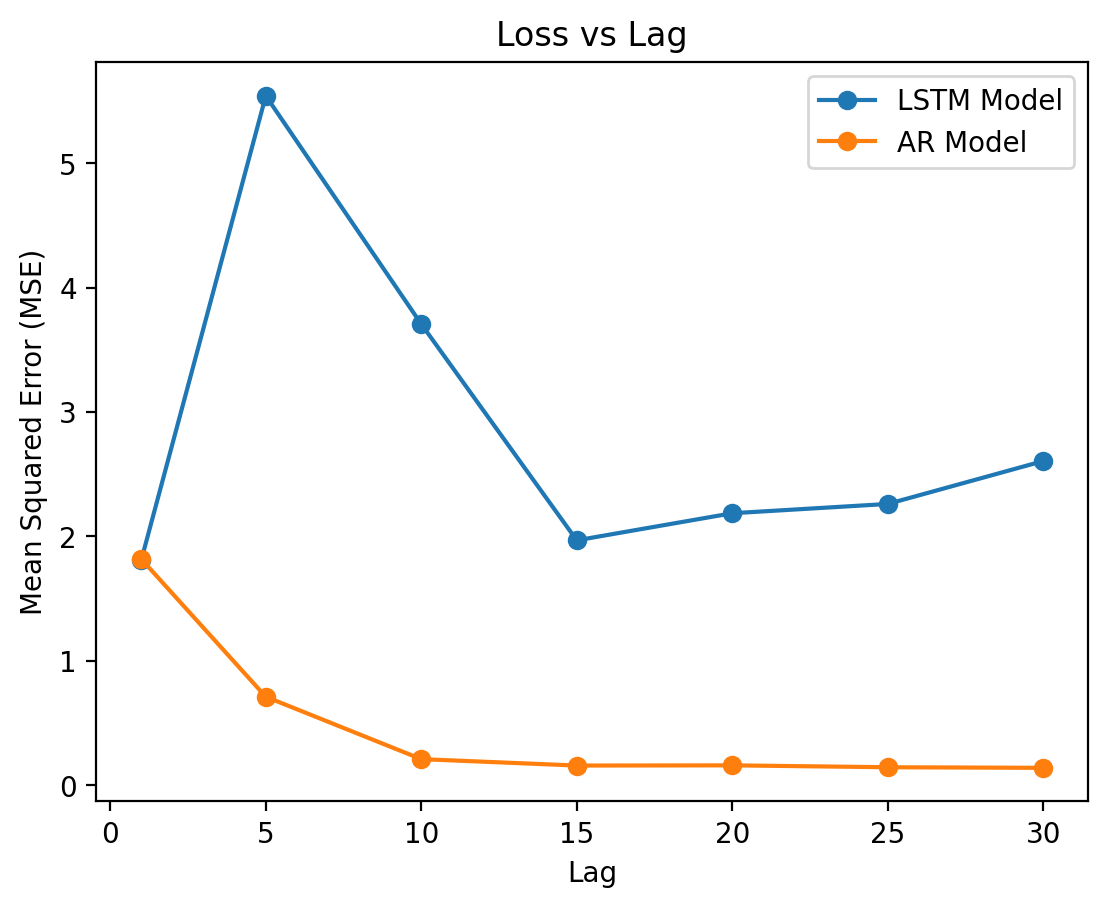

In [37]:
# comparing the mse loss values between the LSTM model and the AR model with the same lag
lags_AR, losses_AR = zip(*loss_table_Ar)
lags_LSTM, losses_LSTM= zip(*loss_table_LSTM)
plt.plot(lags_LSTM, losses_LSTM,label='LSTM Model', marker='o')
plt.plot(lags_AR, losses_AR,label='AR Model', marker='o')
plt.xlabel('Lag')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Loss vs Lag')
plt.legend()
plt.show()

<h3> Using a more complicated dataset : Air passengers dataset

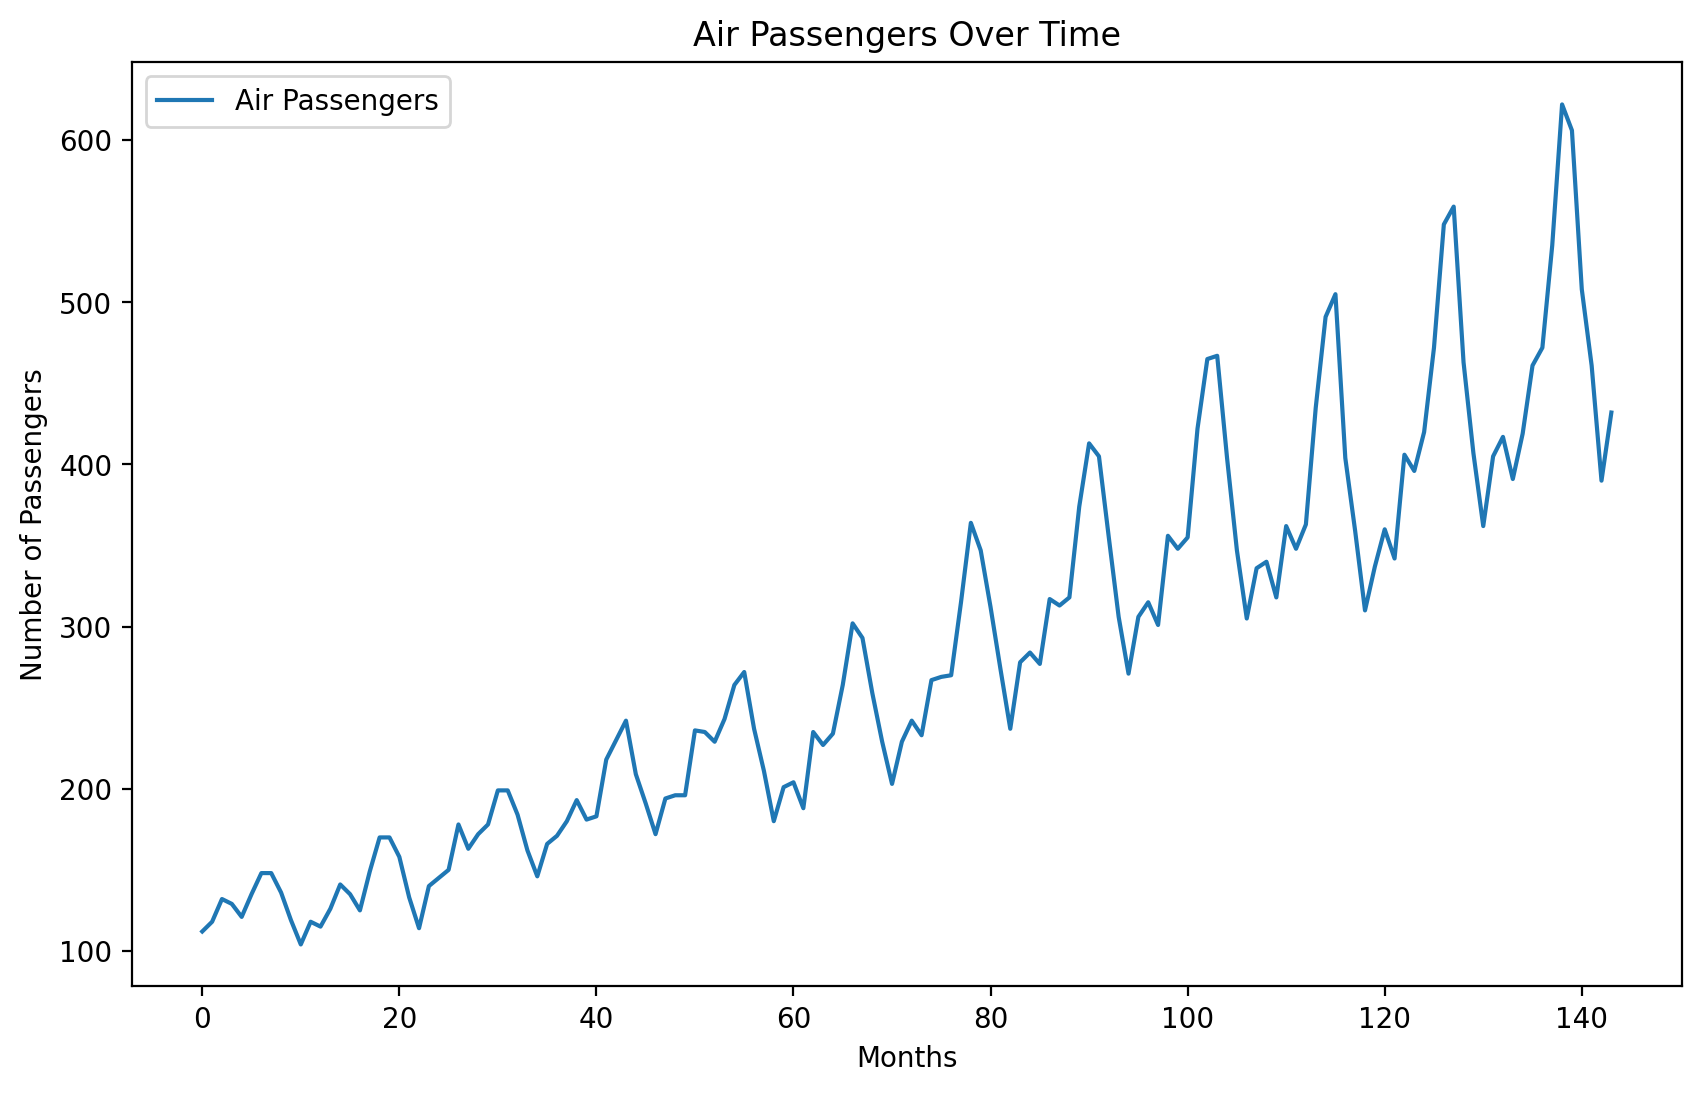

In [38]:
# downloading and plotting the dataset
url_ap = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df_ap = pd.read_csv(url_ap)
df_ap['Month'] = pd.to_datetime(df_ap['Month'])
df_ap.set_index('Month', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(np.array(range(len(df_ap))), df_ap['Passengers'], label='Air Passengers')
plt.title('Air Passengers Over Time')
plt.xlabel('Months')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

In [39]:
# Extract features (X) and target variable (y)
X_ap = np.array(range(len(df_ap)))
y_ap= df_ap['Passengers'].values.flatten().tolist()

split_index_ap = int(0.8 * len(y_ap))
train_data_ap = y_ap[:split_index_ap]
X_train_data_ap = X_ap[:split_index_ap]
test_data_ap = y_ap[split_index_ap:]
X_test_data_ap = X_ap[split_index_ap:]

In [40]:
# example run of the model using a lag of 10
lag_ap = 10
X_train_ap, y_train_ap, months_train_ap = make_dataset(train_data_ap, X_train_data_ap, lag_ap)
reg_ap = LinearRegression().fit(X_train_ap, y_train_ap)
X_test_ap, y_test_ap, months_test_ap = make_dataset(test_data_ap,X_test_data_ap, lag_ap)
y_hat_ap = reg_ap.predict(X_test_ap)
rmse_ap = np.sqrt(mean_squared_error(y_test_ap, y_hat_ap))

print(f"Mean Squared Error (RMSE): {rmse_ap}")

Mean Squared Error (RMSE): 38.86532787604067


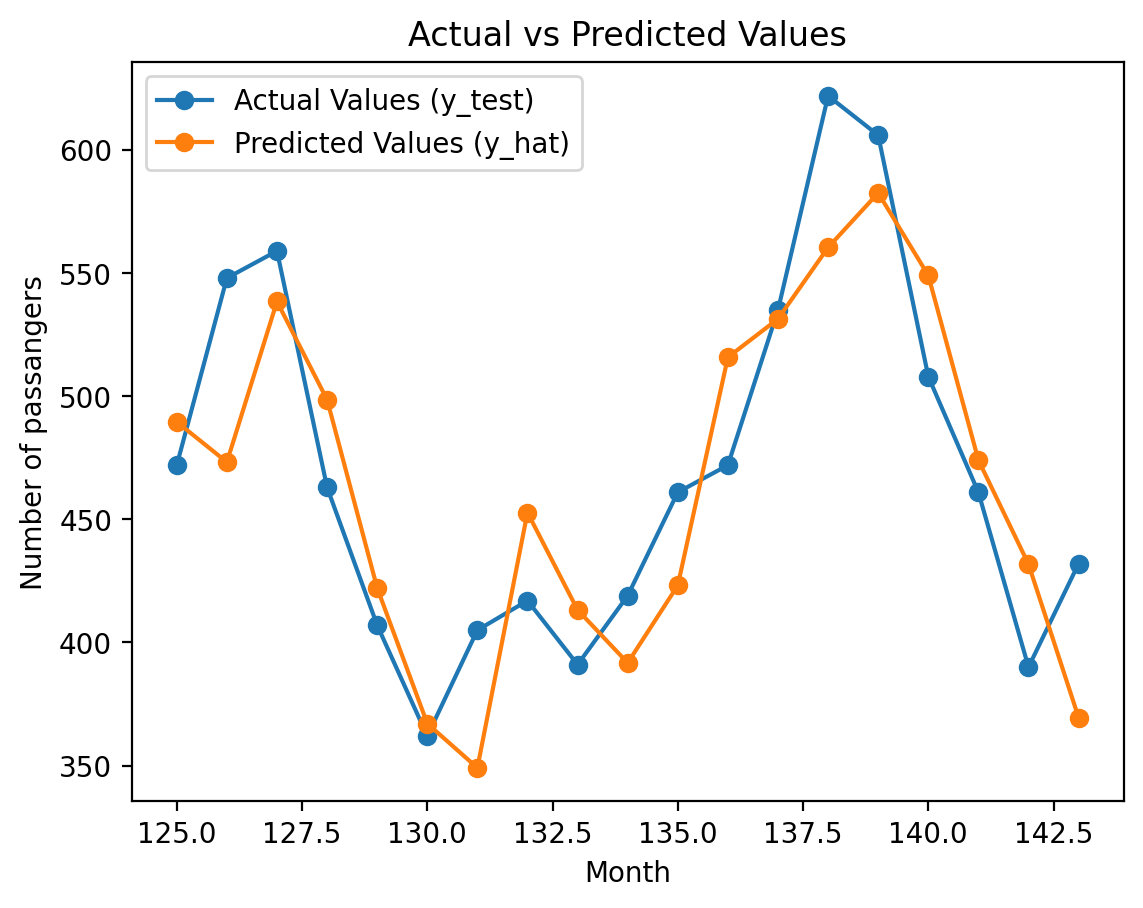

In [41]:
# Ploting the predicted output for lag=10 for the test sequence
plt.plot(months_test_ap, y_test_ap, label='Actual Values (y_test)', marker='o')
plt.plot(months_test_ap, y_hat_ap, label='Predicted Values (y_hat)', marker='o')
plt.xlabel('Month')
plt.ylabel('Number of passangers')
plt.title('Actual vs Predicted Values')


plt.legend()
plt.show()

In [42]:
# Comparing the accuracy values between the AR model and the LSTM model
lag_values = [1, 5, 10, 15, 20, 25]

loss_table_Ar_ap = []
loss_table_LSTM_ap = []
n_features = 1

for lag in lag_values:
    model_1 = AR_model(lag)
    model_2 = custom_LSTM(lag)
    reg1 = model_1.train_AR_model(train_data_ap, X_train_data_ap)
    model_2.train(train_data_ap, X_train_data_ap)

    rmse1 = np.sqrt(model_1.test_AR_model(test_data_ap,X_test_data_ap))
    rmse2 = np.sqrt(model_2.test(test_data_ap,X_test_data_ap))

    loss_table_Ar_ap.append((lag, rmse1))
    loss_table_LSTM_ap.append((lag, rmse2))

1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 160ms/step


1/1 [==============================] - 0s 148ms/step


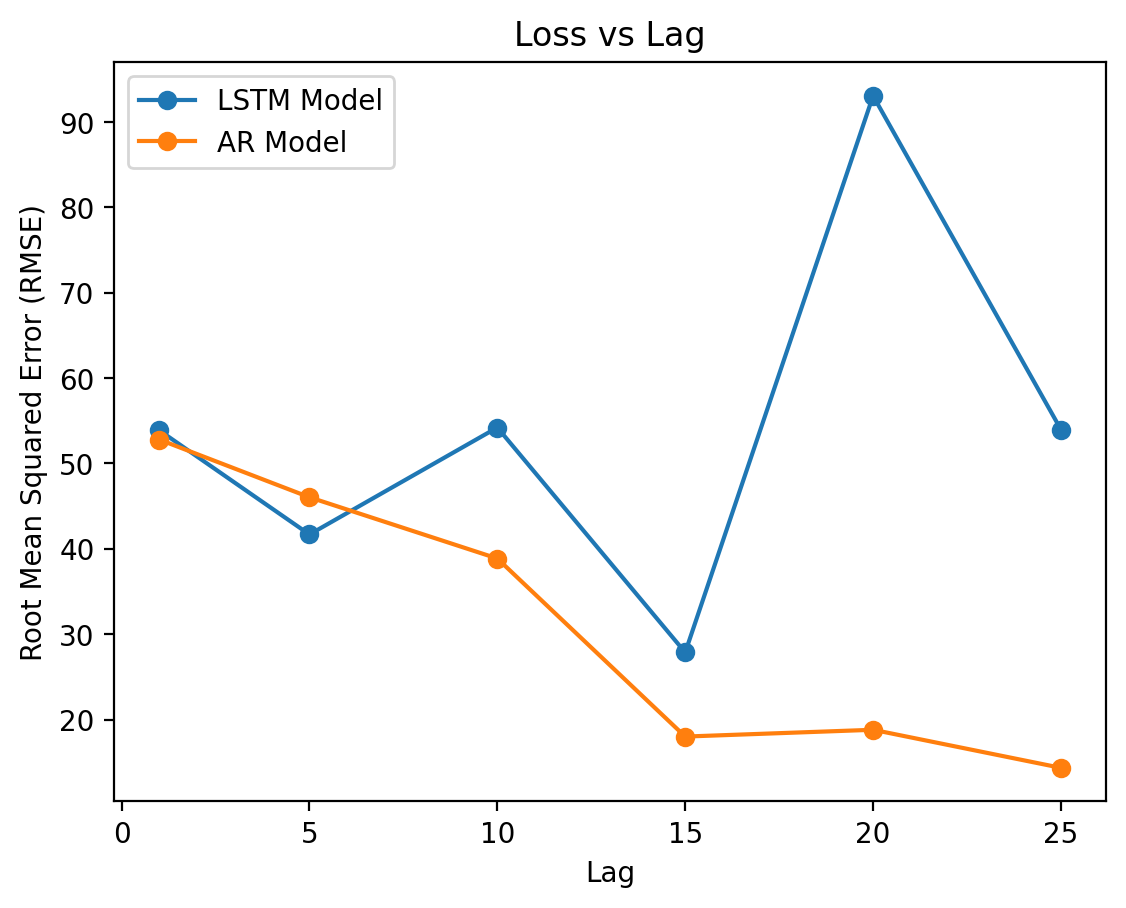

In [43]:
# Visualizing the loss values
lags_AR_ap, losses_AR_ap = zip(*loss_table_Ar_ap)
lags_LSTM_ap, losses_LSTM_ap= zip(*loss_table_LSTM_ap)
plt.plot(lags_LSTM_ap, losses_LSTM_ap,label='LSTM Model', marker='o')
plt.plot(lags_AR_ap, losses_AR_ap,label='AR Model', marker='o')
plt.xlabel('Lag')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Loss vs Lag')
plt.legend()
plt.show()